In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Create a dataset
Define some parameters for the loader:

**batch size**: Number images that used for each iteration of traning

**image_height and Image_width**: size of images

In [3]:
batch_size = 32
img_height = 180
img_width = 180

mount to your google drive and access to shared data in your drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


provide path to the training data

In [8]:
data_dir = "/content/drive/MyDrive/train_small"

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.8,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 80 files belonging to 7 classes.
Using 16 files for training.


In [9]:
# TODO 1: create validation dataset from the provided data
# Edit the code by replacing the underscore
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,   # Use 20% of the images for validation
  subset="validation",
  seed=123,   # Provide a fixed seed to ensure reproducibility
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 80 files belonging to 7 classes.
Using 16 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [11]:
class_names = train_ds.class_names
num_classes = len(train_ds.class_names)
print(class_names)

['bathroom', 'bedroom', 'dining_room', 'exterior', 'interior', 'kitchen', 'living_room']


# Visualize the data
Here are the first nine images from the training dataset:

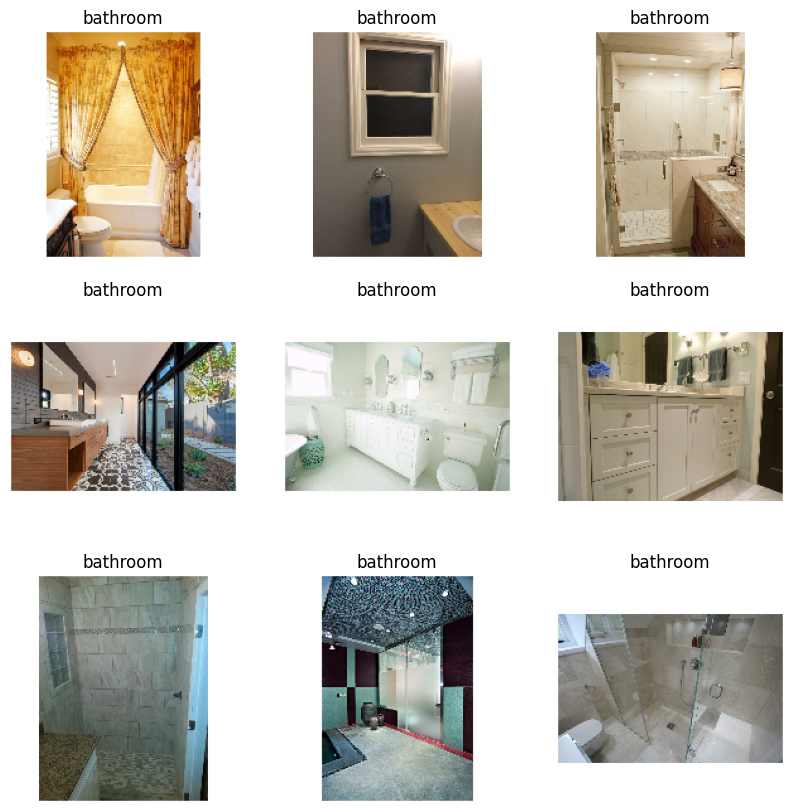

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Use data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation, horizontal flipping and random Zoom. This helps expose the model to different aspects of the training data and reduce overfitting. You can learn more about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [14]:
# TODO 2: Add a RandomRotation layer with factor=0.2
# Edit the code by replacing the underscore
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomFlip('vertical'),
  tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2)
])

Let's repeatedly apply these layers to the same image and see the result.

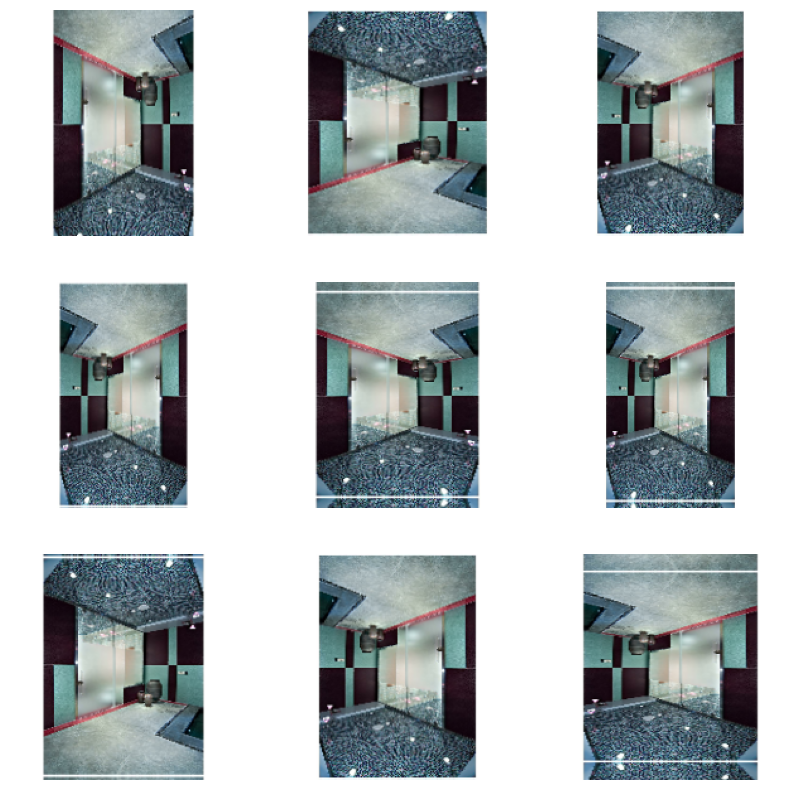

In [15]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

You can add more augmentation layers to get more generalised and then more accurate model

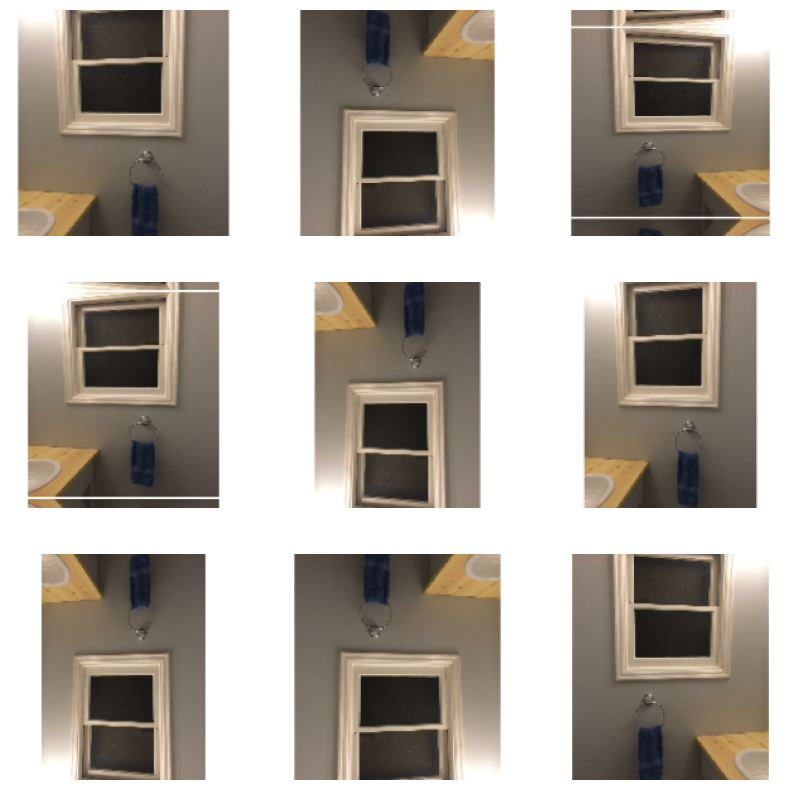

In [28]:
# TODO: Tech Focue Only
# Add more augmentation layers and see how it improves the model performance.
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Rescale pixel values
In a moment, you will download tf.keras.applications.InceptionV3 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

Note: We use InceptionV3 because we use it as base model, you need to change it to model you want to use as base model for your project.

In [17]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Create the base model from the pre-trained convnets
You will create the base model from the **InceptionV3** model. This is pre-trained on the **ImageNet** dataset, a large dataset consisting of 1.4M images and 1000 classes. **ImageNet** is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of **InceptionV3** you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a **InceptionV3** model pre-loaded with weights trained on **ImageNet**. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [29]:
image_size = (img_height, img_width)
image_shape = image_size + (3,)
base_model = tf.keras.applications.InceptionV3(
                     include_top=False,
                     weights='imagenet',
                     input_shape=image_shape
                     )

87910968/87910968 [==============================] - 0s 0us/step


If you would like to achieve more performance you may try another base models. the list of model avilable in Keras you can find [here](https://keras.io/api/applications/)

In [31]:
# TODO: Tech Focus only
# Add different base models and compare the model performance


This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [32]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 4, 4, 2048)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. InceptionV3 has many layers, so setting the entire model's trainable flag to False will freeze all of them.




In [33]:
base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 89, 89, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 89, 89, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 89, 89, 32)           0         ['batch_normalizati

## Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 2048-element vector per image.

In [35]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


You can potentially add more layers between base layer and prediction layer (bext) here to more fine tune the model and potentially boost the accuracy

In [67]:
# TODO: Tech Focus only
# add more layers and see if it improves the model performance


(16, 2048)


Apply a tf.keras.layers.Dense layer to convert these features into 7 class prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [37]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 7)


# Build and Compile Model
Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.


***Note***: Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).


***Note***: if you define more layer in previous steps, you need to add them here to layers of model to be built and compiled.

In [49]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

# TODO 3: Create the model using tf.keras.Model() function
# Edit the code by replacing the underscore
model = tf.keras.Model(
    inputs,outputs
)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.math.truediv_10 (TFOpLa  (None, 180, 180, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_10 (TFOpL  (None, 180, 180, 3)       0         
 ambda)                                                          
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0   

It is interesting to see how the base model without fine tuninng perform: As you can see it very disappointing :-)

In [50]:
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

1/1 [==============================] - 5s 5s/step - loss: 1.9962 - accuracy: 0.1875
initial loss: 2.00
initial accuracy: 0.19


## Train the Model

Now we can start traning which means fine tuning the base model which is InceptionV3 for now. We start with small number of epoch (10) to see how the final model perofrm.

In [64]:
early = tf.keras.callbacks.EarlyStopping(patience=10,
                                          min_delta=0.01,
                                          restore_best_weights=True)
initial_epochs = 10

# TODO 4: train the model using the model.fit() function
# Edit the code by replacing the underscore
history = model.fit(train_ds,
                    validation_data=None,
                    epochs=initial_epochs,
                    callbacks=[early])

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 1.5763 - accuracy: 0.3125

1/1 [==============================] - 1s 743ms/step - loss: 1.5763 - accuracy: 0.3125
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 1.1985 - accuracy: 0.5000

1/1 [==============================] - 1s 731ms/step - loss: 1.1985 - accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 1.1652 - accuracy: 0.5000

1/1 [==============================] - 1s 902ms/step - loss: 1.1652 - accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 0.8334 - accuracy: 0.6875

1/1 [==============================] - 1s 952ms/step - loss: 0.8334 - accuracy: 0.6875
Epoch 5/10
1/1 [==============================] - ETA: 0s - loss: 0.7938 - accuracy: 0.8125

1/1 [==============================] - 1s 727ms/step - loss: 0.7938 - accuracy: 0.8125
Epoch 6/10
1/1 [==============================] - ETA: 0s - loss: 0.7118 - accuracy: 0.7500

1/1 [==============================] - 1s 761ms/step - loss: 0.7118 - accuracy: 0.7500
Epoch 7/10
1/1 [==============================] - ETA: 0s - loss: 0.7490 - accuracy: 0.6250

1/1 [==============================] - 1s 740ms/step - loss: 0.7490 - accuracy: 0.6250
Epoch 8/10
1/1 [==============================] - ETA: 0s - loss: 0.6140 - accuracy: 0.7500

1/1 [==============================] - 1s 740ms/step - loss: 0.6140 - accuracy: 0.7500
Epoch 9/10
1/1 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.8125

1/1 [==============================] - 1s 738ms/step - loss: 0.5635 - accuracy: 0.8125
Epoch 10/10
1/1 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.8125

1/1 [==============================] - 1s 745ms/step - loss: 0.5260 - accuracy: 0.8125


## Learning (Accuracy-Loss) curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the InceptionV3 base model as a fixed feature extractor for transfer learning.

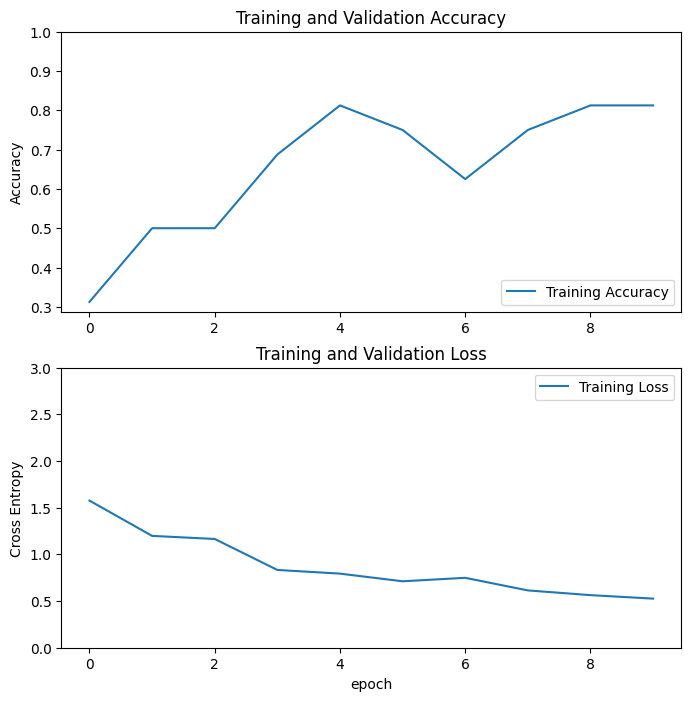

In [74]:
acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

loss = history.history['loss']
#val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()